# Import Required Libraries

In [1]:
import os
import cv2
import gdcm
import numpy as np
from matplotlib import pyplot, image
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage
from glob import glob
pyplot.style.use('dark_background')

# Read and Plot Functions 

In [2]:
def read_image(filepath):
    # Read grayscale DICOM image
    image = cv2.imread(filepath)
    return image

def generate_histogram(image):
    # Calculate Histogram
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    return histogram

def save_processed_image(img, directory, filename):
    processed_filepath = directory + 'p-' + filename
    cv2.imwrite(processed_filepath, img)

def save_histogram(histogram, h_directory, filename):
    pyplot.figure(figsize=(2,2))
    pyplot.xlim([0, 250])
    pyplot.ylim([0, 400])
    pyplot.axis('off')
    pyplot.plot(histogram)
    pyplot.savefig(h_directory + "h-" + filename, bbox_inches=0)
    pyplot.close()

In [3]:
def plot_image(image):
    imgplot = pyplot.imshow(image, cmap=pyplot.cm.bone)
    
def plot_histogram(histogram):
    # configure and draw the histogram figure
    pyplot.figure()
    pyplot.title("CT-Scan Histogram")
    pyplot.xlabel("grayscale value")
    pyplot.ylabel("pixels")
    pyplot.xlim([0, 256])
    # TODO: qual será o limite de y?
    pyplot.ylim([0, 400])
    pyplot.plot(histogram)
    pyplot.show()

# Image Processing Functions 

In [4]:
# Remove skull/ventricle pixels (TODO: Optimize this)
def remove_skull_and_ventricles(img):
    img[np.where((img >= [253,253,253]).all(axis = 2))] = [0,0,0]
    img[np.where((img <= [100,100,100]).all(axis = 2))] = [0,0,0]
    return img

def median_filter(img):
    img = ndimage.median_filter(img, 3)
    return img

# Returns image biggest_contour and mask
def find_biggest_contour(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    if contour_sizes == []: 
        biggest_contour = np.array([[0, 0]])
    else:
        biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask 

# Remove soft tissues using biggest contour
def remove_soft_tissues(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 100, 253, 0)
    biggest_contour, mask = find_biggest_contour(thresh)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    biggest_contour_image = np.bitwise_and(img, mask, mask)
    return biggest_contour_image, imgray

# use threshold to isolate likely areas of bleeding
def isolate_hemorrhages(img):
    # TODO: maybe get a average value for normal cerebral mass pixel color to use on threshold lower limit
    # Global Threshold
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret2, thresh = cv2.threshold(img, 140, 253, cv2.THRESH_BINARY)
    final_image = np.bitwise_and(img, thresh, thresh)
    return final_image
    
def process_file(filename, directory):
    img = read_image(directory + "/" + filename)
    img_no_skull = remove_skull_and_ventricles(img)
    img_median_filter = median_filter(img_no_skull)
    img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
    final_img = isolate_hemorrhages(img_no_soft_tissues)
    return final_img

def process_exam(filelist, i_dir):
    # i_dir = /home/dataset/1/pngs
    exam_dir = os.path.normpath(i_dir + os.sep + os.pardir)
    p_dir = exam_dir + "/processed/"
    h_dir = exam_dir + "/histograms/"
    os.makedirs(p_dir, exist_ok=True)  
    os.makedirs(h_dir, exist_ok=True)
    for filename in filelist:
        if ".png" in filename:
            processed = process_file(filename, i_dir)
            save_histogram(generate_histogram(processed), h_dir, filename)
            save_processed_image(processed, p_dir, filename)

# Process Images & Save Files

In [5]:
dataset_dir = "/home/rodrigo/Batch/"
dir_list = glob(dataset_dir + "[0-9]*")
total = len(dir_list)
complete = 1

for exam_dir in dir_list:
    print("processing exam " + os.path.basename(exam_dir))
    image_dir = exam_dir + "/pngs"
    filelist = os.listdir(image_dir)
    process_exam(filelist, image_dir)
    print(str(complete) + "/" + str(total))
    complete += 1

processing exam 89
1/10
processing exam 490
2/10
processing exam 102
3/10
processing exam 159
4/10
processing exam 109
5/10
processing exam 243
6/10
processing exam 303
7/10
processing exam 320
8/10
processing exam 0
9/10
processing exam 486
10/10


# Check Processing Step by Step

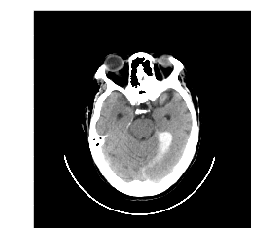

In [6]:
img = read_image('/home/rodrigo/Batch/159/pngs/CT11.png')
plot_image(img)

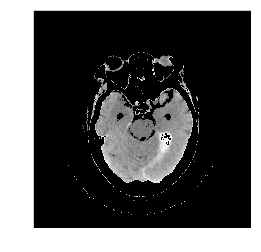

In [7]:
img_no_skull = remove_skull_and_ventricles(img)
plot_image(img_no_skull)

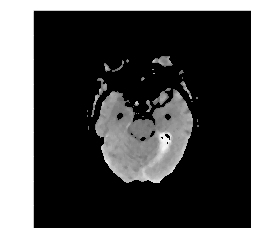

In [8]:
img_median_filter = median_filter(img_no_skull)
plot_image(img_median_filter)

(224, 224, 3)


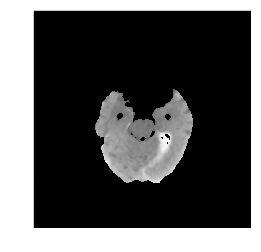

In [10]:
img_no_soft_tissues, imgray = remove_soft_tissues(img_median_filter)
print(img_no_soft_tissues.shape)
plot_image(img_no_soft_tissues)

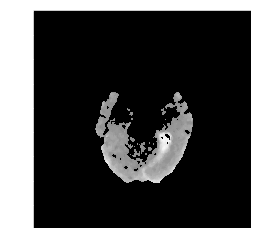

In [11]:
final_img = isolate_hemorrhages(img_no_soft_tissues)
plot_image(final_img)